# About this project

- Summarize your objectives for this NLP project - what you want to achieve
> Being able to detect spam text messages 

- Describe the text preprocessing you do, including EDA
> load csv file with pandas, remove duplicate data (about ~400 records are duplicates)

- Build your model and pick relevant metrics. Train a baseline
> Precision and Recall for metrics

- Show which approach you take to increase the performance of the model
> Pretraining the model with Language Model before training a classifier and use the encoder

### Final

# Install Dependencies

In [2]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.text.all import *

# Load Data

In [6]:
ds_folder = Path('../../Datasets/SMS Spam Collection Dataset')
clean_folder = Path(ds_folder/'clean')
train_folder = Path(clean_folder/'train')
valid_folder = Path(clean_folder/'valid')

In [2]:
ds_sms = pd.read_csv(ds_folder/'spam.csv', 
                        usecols=[0,1],
                        names=['SPAM','Message'],
                        header=0, 
                        low_memory=False)
ds_sms.head(20)

SPAM  \
0    ham   
1    ham   
2   spam   
3    ham   
4    ham   
5   spam   
6    ham   
7    ham   
8   spam   
9   spam   
10   ham   
11  spam   
12  spam   
13   ham   
14   ham   
15  spam   
16   ham   
17   ham   
18   ham   
19  spam   

                                                                                                                                                                                                 Message  
0                                                                                        Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...  
1                                                                                                                                                                          Ok lar... Joking wif u oni...  
2                                            Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's  
3                                                                                                                                                      U dun say so early hor... U c already then say...  
4                                                                                                                                          Nah I don't think he goes to usf, he lives around here though  
5                                                    FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv  
6                                                                                                                          Even my brother is not like to speak with me. They treat me like aids patent.  
7                                       As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune  
8                                          WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.  
9                                             Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030  
10                                                                                         I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.  
11                                                              SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info  
12                                           URGENT! You have won a 1 week FREE membership in our �100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18  
13  I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.  
14                                                                                                                                                                   I HAVE A DATE ON SUNDAY WITH WILL!!  
15                                                 XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL  
16                                                                                                                                                                            Oh k...i'm watching here:)  
17                                                                                               

In [3]:
ds_sms['SPAM'] = ds_sms['SPAM'].astype('category')

In [4]:
ds_sms['SPAM'].cat.categories # 0 = majority (negatives), 1 = minority (positives)

Index(['ham', 'spam'], dtype='object')

# Sanitize Data

- Drop duplicates
- Class balance... even out the ratios of ham and spam

In [5]:
ds_sms.drop_duplicates(['Message'], inplace=True)

In [6]:
spam_wgt = len(ds_sms[ds_sms['SPAM']=='ham'])/len(ds_sms[ds_sms['SPAM']=='spam'])
spam_wgt

6.915773353751915

In [7]:
ds_sms = ds_sms.append([ds_sms[ds_sms['SPAM']=='spam']]*5, ignore_index=True)

In [11]:
len(ds_sms[ds_sms['SPAM']=='ham']), len(ds_sms[ds_sms['SPAM']=='spam']), len(ds_sms)

(4516, 3918, 8434)

# Sanitize Data

In [12]:
train_valid_perc = 0.8 # how much of the file is train

# remove train and valid files if exist
if train_folder.exists():
    shutil.rmtree(train_folder)
os.mkdir(train_folder)
if valid_folder.exists():
    shutil.rmtree(valid_folder)
os.mkdir(valid_folder)

# random split
train_idx = []
valid_idx = []
train_sum = math.floor(len(ds_sms)*train_valid_perc)
for i in range(0,train_sum):
    chosen_idx = random.choice(ds_sms.index)
    while chosen_idx in train_idx:
        chosen_idx = random.choice(ds_sms.index)
    train_idx.append(chosen_idx)

    
# Save to new folder
for index, row in ds_sms.iterrows():
    folder = train_folder if index in train_idx else valid_folder
    # ham or spam
    folder = Path(folder/row['SPAM'])
    # Make the folder if it doesn't exist yet
    if not folder.exists():
        os.mkdir(folder)

    
    # Clean unicodes
    msg = re.sub('[\s\n]',' ', row['Message'])
    msg = re.sub('[^\w\.,:;\'\"\(\)\?\-!\n\s]', '', msg)
    
    # DELETE REMAINING UNICODES
    msg = msg.encode('ascii','ignore').decode('utf-8')
    
    filename = str(index) + ".txt"
    clean_file = open(folder/filename, "w", encoding='utf8') 
    clean_file.write(msg)
    clean_file.close()

# Tokenize

In [13]:
# remove clean_tok dir
outdir = Path(ds_folder/'clean_tok')
if outdir.exists():
    shutil.rmtree(outdir)
    
# Save toks without error
tokenize_folder(clean_folder,folders=['train','valid'], n_workers=0)

Path('../../Datasets/SMS Spam Collection Dataset/clean_tok')

# Language Model Pretraining

In [8]:
dls_lm = DataBlock(
    blocks=TextBlock.from_folder(clean_folder, is_lm=True),
    get_items=partial(get_text_files, folders=['train', 'valid']), 
    splitter=GrandparentSplitter()
).dataloaders(clean_folder, path=clean_folder, bs=128, seq_len=216, num_workers=0)

In [15]:
dls_lm.show_batch(max_n=2)

# Train LM

In [16]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, 
    metrics=Perplexity()).to_fp16()

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=0.2089296132326126)

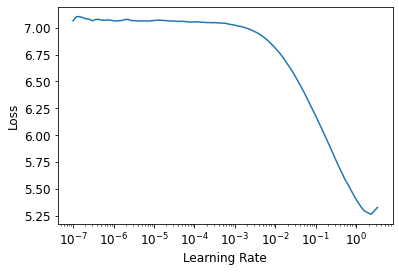

In [151]:
learn.lr_find()

In [17]:
learn.fine_tune(10, 1e-2, freeze_epochs=5, wd=0.5)

In [18]:
learn.save_encoder('SMS_LM_encoder')

# Classifier

In [10]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_folder(clean_folder, vocab=dls_lm.vocab), CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'valid']),
    splitter=GrandparentSplitter()
).dataloaders(clean_folder, path=clean_folder, bs=256, seq_len=216, num_workers=0)

In [11]:
dls_clas.show_batch()

# Train Classifier

Both have a range of 0. to 1., perfect scores are 1.0
- Precision = TruePositives / (TruePositives + FalsePositives) 
- Recall = TruePositives / (TruePositives + FalseNegatives)

In [12]:
learn2 = text_classifier_learner(dls_clas, AWD_LSTM, 
                                 metrics=[Precision(),Recall()]).to_fp16()

In [13]:
learn2 = learn2.load_encoder('SMS_LM_encoder')

In [14]:
learn2.fine_tune(10, 2e-5, freeze_epochs=5, wd=0.3)

In [16]:
learn2.show_results()

In [17]:
interp = ClassificationInterpretation.from_learner(learn2)
# interp.plot_confusion_matrix()

RuntimeError: index_select(): Expected dtype int64 for index

# Save Model

In [123]:
learn2.export(fname='models/sms_spam.pkl')